<a href="https://colab.research.google.com/github/IndeewaAmarasinghe/RP-2024-25J-125-Crop-yield-prediction---Paddy-harvest-/blob/IT21227868-Rice-Variety-Recommendation/RandomForestClassifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
import pandas as pd

# Mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd

# Load the datasets
varieties_file_path = '/content/drive/MyDrive/Rice Genie/RiceVarietiesData.xlsx'
district_file_path = '/content/drive/MyDrive/Rice Genie/SriLankaDistricts.csv'

varieties_data = pd.read_excel(varieties_file_path, sheet_name='Sheet1')
district_data = pd.read_csv(district_file_path)

In [ ]:
#combined_data = pd.merge(varieties_data, district_data, how='cross')
combined_data = pd.merge(varieties_data, district_data, how='inner', on='Recommendation')


In [ ]:
from google.colab import files

# Save the processed data to a CSV file
combined_data.to_csv('/content/sample_data/full_data.csv', index=False)

# Download the CSV file
files.download('/content/sample_data/full_data.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
def convert_maturity_to_numeric(value):
    if isinstance(value, str) and '-' in value:
        parts = value.split('-')
        return (int(parts[0]) + int(parts[1])) / 2
    try:
        return float(value)
    except ValueError:
        return np.nan

# Convert 'Maturity (days)' to numeric averages
combined_data['Maturity (days)'] = combined_data['Maturity (days)'].apply(convert_maturity_to_numeric)
combined_data.dropna(subset=['Maturity (days)'], inplace=True)

In [ ]:
# Create a list of recommendation keywords/phrases that indicate suitability
recommendation_keywords = [
    "Low Country Wet Zone",
    "Coastal saline areas",
    "High potential area",
    "Rainfed areas",
    "Wet Zone",
    "Kalutara and Galle Districts",
    "Saline prone areas",
    "Northern region",
    "Saline areas",
    "Iron toxic soil and acidic soil",
    "Major irrigation in Dry Zone and Intermediate Zone",
    "Southern province",
    "High potential areas in Low Country Wet Zone"
]

# Creating a new column 'Suitability' based on multiple recommendation criteria
combined_data['Suitability'] = combined_data.apply(
    lambda row: 1 if (any(keyword.lower() in str(row['Recommendation']).lower() for keyword in recommendation_keywords)
                      and row['Average Yield (t/ha)'] >= 5.0) else 0,
    axis=1
)


In [ ]:
print("Column names in rice varieties dataset:", varieties_data.columns)
print("Column names in merged dataset:", combined_data.columns)

Column names in rice varieties dataset: Index(['Variety Name', 'Year of Release', 'Parentage', 'Average Yield (t/ha)',
       'Maturity (days)', 'Age Group', 'Basal Leaf Sheath Colour',
       'Recommendation', 'Brown Rice Recovery (%)', 'Milling Recovery (%)',
       'Head Rice Recovery (%)', 'Gelatinization Temperature',
       '1000 Grain Weight (g)', 'Grain Shape', 'Pericarp Colour',
       'Bushel Weight (Kg)', 'Reaction to Pest and Diseases'],
      dtype='object')
Column names in merged dataset: Index(['Variety Name', 'Year of Release', 'Parentage', 'Average Yield (t/ha)',
       'Maturity (days)', 'Age Group', 'Basal Leaf Sheath Colour',
       'Recommendation', 'Brown Rice Recovery (%)', 'Milling Recovery (%)',
       'Head Rice Recovery (%)', 'Gelatinization Temperature',
       '1000 Grain Weight (g)', 'Grain Shape', 'Pericarp Colour',
       'Bushel Weight (Kg)', 'Reaction to Pest and Diseases', 'Province',
       'District', 'AnnualTemperature', 'Annual Humidity', 'Annual 

In [ ]:
from sklearn.preprocessing import LabelEncoder

le_temperature = LabelEncoder()
le_rainfall = LabelEncoder()

# Encoding 'AnnualTemperature' and 'Annual Rainfall' into numerical values
combined_data['Annual Temperature'] = le_temperature.fit_transform(combined_data['Annual Temperature'])
combined_data['Annual Rainfall'] = le_rainfall.fit_transform(combined_data['Annual Rainfall'])

In [ ]:
# Define features (X) and target (y)
features = [
    'Average Yield (t/ha)', 'Maturity (days)', 'Annual Temperature', 'Annual Rainfall'
]
X = combined_data[features]
y = combined_data['Suitability']


In [ ]:
from sklearn.model_selection import train_test_split

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
from sklearn.ensemble import RandomForestClassifier

# Train the Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [ ]:
from sklearn.metrics import classification_report, accuracy_score

# Predict and evaluate the model
y_pred = rf_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print("Accuracy:", accuracy)
print(report)

Accuracy: 0.9965277777777778
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       284
           1       1.00      0.75      0.86         4

    accuracy                           1.00       288
   macro avg       1.00      0.88      0.93       288
weighted avg       1.00      1.00      1.00       288



In [ ]:
from sklearn.model_selection import cross_val_score
import numpy as np

# Perform 5-fold cross-validation
cv_scores = cross_val_score(rf_model, X, y, cv=5, scoring='accuracy')
mean_cv_score = np.mean(cv_scores)
print("Mean Cross-Validation Score:", mean_cv_score)

Mean Cross-Validation Score: 0.9177821331784746


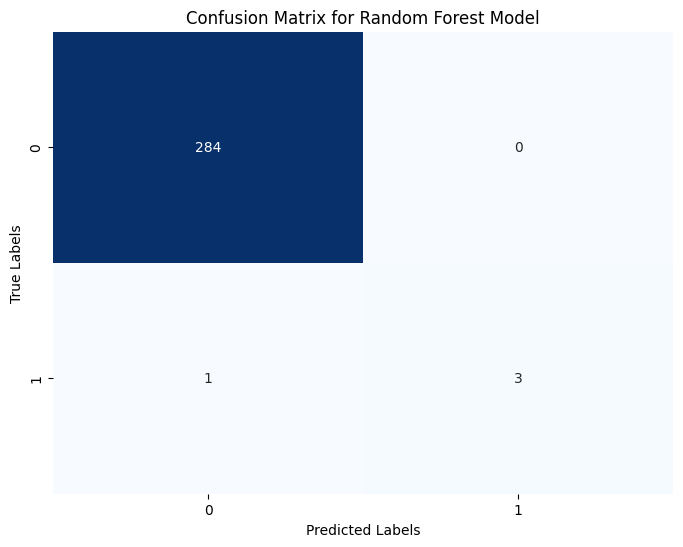

In [ ]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Generate the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap="Blues", fmt="d", cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix for Random Forest Model')
plt.show()


In [ ]:
def predict_suitable_varieties_for_district(district_name, district_data, varieties_data, model):
    # Get the environmental conditions for the specified district
    district_conditions = district_data[district_data['District'] == district_name].iloc[0]

    # Extract the relevant features for prediction
    annual_temperature = le_temperature.transform([district_conditions['Annual Temperature']])[0]
    annual_rainfall = le_rainfall.transform([district_conditions['Annual Rainfall']])[0]

    # Create a dataframe for prediction with the relevant features of each variety combined with district conditions
    prediction_data = varieties_data.copy()
    prediction_data['Annual Temperature'] = annual_temperature
    prediction_data['Annual Rainfall'] = annual_rainfall

    # Convert maturity to numeric where applicable
    prediction_data['Maturity (days)'] = prediction_data['Maturity (days)'].apply(convert_maturity_to_numeric)
    prediction_data.dropna(subset=['Maturity (days)'], inplace=True)

    # Prepare the feature set
    X_pred = prediction_data[['Average Yield (t/ha)', 'Maturity (days)', 'Annual Temperature', 'Annual Rainfall']]

    # Predict suitability for each rice variety
    prediction_data['Suitability'] = model.predict(X_pred)

    # Filter for suitable varieties
    suitable_varieties = prediction_data[prediction_data['Suitability'] == 1]

    # Return the suitable varieties
    return suitable_varieties[['Variety Name', 'Average Yield (t/ha)', 'Maturity (days)', 'Gelatinization Temperature', 'Grain Shape']]

In [ ]:
recommended_varieties_kandy = predict_suitable_varieties_for_district('Jaffna', district_data, varieties_data, rf_model)

# Print the results
print("Recommended Rice Varieties for Kandy District:")
print(recommended_varieties_kandy)

Recommended Rice Varieties for Kandy District:
   Variety Name  Average Yield (t/ha)  Maturity (days)  \
20       Bg 310                   5.6             96.5   
38       Bg 406                   5.0            120.0   
41       Bw 400                   5.0            120.0   
43       At 402                   6.0            117.5   
45       At 401                   5.0            120.0   
53       Bg 369                   5.5            104.0   
60       At 354                   5.0            105.0   
69       Bw 451                   5.5            120.0   
70       Bw 451                   5.5            120.0   
91       Bg 359                   5.0            104.0   

   Gelatinization Temperature          Grain Shape  
20               Intermediate    Intermediate Bold  
38                        Low    Intermediate Bold  
41               Intermediate    Intermediate Bold  
43               Intermediate  Intermediate Medium  
45               Intermediate          Long Mediu